# Accuracy and Convergence Speed of LCG vs Python's Built-in Random Module

## Objective
The objective of this experiment is to compare the **accuracy** and **convergence speed** of two random number generators (RNGs):
1. **Linear Congruential Generator (LCG):** A simple PRNG commonly used in early computing.
2. **Python's Built-in Random Module:** Based on the Mersenne Twister, a widely-used RNG known for its high quality and long period.

By using these RNGs in a Monte Carlo simulation to estimate $\pi$, we aim to assess their performance and behavior in terms of:
- Accuracy of the estimate.
- Convergence speed ($1/\sqrt{N}$).

---

## Methodology

### 1. Monte Carlo Simulation: Estimation of $\pi$ using Buffon's Needle

We estimate $\pi$ using Buffon's Needle experiment, based on the following steps:

1. Consider a floor with parallel lines spaced at a distance $d$ apart ($d > 0$).
2. Randomly "drop" a needle of length $l$ ($l \leq d$) onto the floor.
3. The needle intersects a line if:

   $y \leq \frac{l}{2} \sin(\theta)$

   where $y$ is the distance of the needle's center from the nearest line, and $\theta$ is the angle between the needle and the parallel lines.

4. Simulate a large number of needle drops ($N$) by generating random values for $y$ (uniformly in $[0, d/2)$) and $\theta$ (uniformly in $[0, \pi)$).
5. Count the number of needles ($N_{\text{intersect}}$) that intersect a line.
6. Estimate $\pi$ using the probability formula:

   $$\pi \approx \frac{2lN}{dN_{\text{intersect}}}$$

This method demonstrates how the randomness of needle drops provides a probabilistic way to calculate $\pi$.

---

### 2. Random Number Generators

- **LCG Implementation:**

  $$X_{n+1} = (a \cdot X_n + c) \mod m$$

  Parameters used:
  - $a = 3$
  - $c = 7$
  - $m = 10$
  - Seed: runtime timestamp

- **Python's Built-in RNG:** Utilizes the `random` module, which is based on the Mersenne Twister algorithm.

---

### 3. Experiment Design

#### Metrics:
1. **Accuracy:** Absolute error of the estimate:

   $$\text{Error} = |\hat{\pi} - \pi|$$

2. **Convergence Speed:** Rate at which the error decreases with increasing $N$, following the expected $1/\sqrt{N}$ behavior.

#### Steps:
1. Perform Monte Carlo simulations using each RNG for a range of $N$ (e.g., $10^2$ to $10^6$).
2. For each $N$, compute the estimate of $\pi$ and its error.
3. Repeat the experiment for multiple independent runs to compute variance and stability of the estimates.
4. Compare the results (accuracy, convergence) between the two RNGs.

---

## Expected Results

### 1. Accuracy
- Plot the **absolute error** vs. $N$ on a log-log scale for both RNGs.
- Expectation: Both RNGs should achieve similar accuracy, as Monte Carlo error depends primarily on $1/\sqrt{N}$, not the quality of the RNG (as long as the RNG is "random enough").

### 2. Convergence Speed
- Compare how quickly the error decreases for each RNG as $N$ increases.
- Expectation: Python's RNG might converge more smoothly, especially at larger $N$, due to better randomness properties, while LCG may show more fluctuations.

---

**Import the necessary functionality**

In [32]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "scripts") )

from scripts.common import get_qo_arev_truly_random_number as true_entropy
from scripts.simulators import estimate_pi_buffon
from scripts.common import are_we_there_yet as calc_error
from scripts.randomNGs import lcg

import numpy as np
import random
import matplotlib.pyplot as plt

## Buffon's Needle Simulation

This section introduces an alternative method for estimating π using Buffon's Needle experiment. It simulates a scenario where a needle of length L is dropped onto a surface with parallel lines spaced D apart (L≤D). The probability of the needle crossing a line is used to estimate π.

In [25]:
NEEDLE_LENGTH = 1
LINE_SPACING = 2
NUM_NEEDLES = 1000000

THRESHOLD = 0.01

In [ ]:
estimate = estimate_pi_buffon(NEEDLE_LENGTH, LINE_SPACING, NUM_NEEDLES)
print(f"Estimated π: {estimate}\nError: {calc_error(estimate)}")

### Experiment: Accuracy

In [82]:
def calc_plot_accuracy(needle_length, spacing, num_needles, seed_range):
    lcg_errors = []
    random_errors = []
    
    for seed in range(seed_range):
        lcg.seed(seed)
        random.seed(seed)
    
        pi_estimate_lcg = estimate_pi_buffon(needle_length, spacing, num_needles, rng=lcg)
        pi_estimate_random = estimate_pi_buffon(needle_length, spacing, num_needles)
        
        lcg_errors.append(calc_error(pi_estimate_lcg))
        random_errors.append(calc_error(pi_estimate_random))
    
    plt.figure(figsize=(8, 6))
    plt.boxplot([lcg_errors, random_errors], labels=["LCG", "Random's RNG"])
    plt.ylabel("Absolute Error")
    plt.title(f"Accuracy Comparison at N = {NUM_NEEDLES}")
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.show()


In [87]:
NEEDLE_LENGTH = 1
LINE_SPACING = 2
NUM_NEEDLES = 10 ** 3

SEED_RANGE = 100

In [ ]:
calc_plot_accuracy(NEEDLE_LENGTH, LINE_SPACING, NUM_NEEDLES, SEED_RANGE)

In [ ]:
NEEDLE_LENGTH = 1
LINE_SPACING = 2
NUM_NEEDLES = 10 ** 4

SEED_RANGE = 100

In [ ]:
calc_plot_accuracy(NEEDLE_LENGTH, LINE_SPACING, NUM_NEEDLES, SEED_RANGE)

### Experiment: Convergence Speed

In [27]:
def calculate_convergence(needle_length, spacing, num_needles):
    # Define number of needles for each simulation
    needle_counts = np.logspace(1, np.log10(num_needles), num=100, dtype=int)
    errors = []
    errors_orig = []
    
    # Compute the absolute error for each needle count
    for n in needle_counts:
        pi_estimate = np.median([estimate_pi_buffon(needle_length, spacing, n, rng=lcg) for _ in range(10)])
        pi_estimate_orig = np.median([estimate_pi_buffon(needle_length, spacing, n) for _ in range(10)])
    
        errors.append(calc_error(pi_estimate))
        errors_orig.append(calc_error(pi_estimate_orig))
        
    return needle_counts, errors, errors_orig
        
def handle_plotting(needle_counts, errors, errors_orig):
    plt.figure(figsize=(8, 6))
    plt.loglog(needle_counts, errors, label="Buffon's Needle Error: LCG")
    plt.loglog(needle_counts, errors_orig, label="Buffon's Needle Error: Random")
    plt.loglog(needle_counts, 1 / np.sqrt(needle_counts), label="1 / sqrt(N) (Expected)", linestyle="--")
    plt.xlabel("Number of Needles")
    plt.ylabel("Absolute Error")
    plt.title("Convergence Rate of Buffon's Needle Experiment")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

In [28]:
NEEDLE_LENGTH = 1
LINE_SPACING = 2
NUM_NEEDLES = 10 ** 3

In [ ]:
needle_counts, errors, errors_orig = calculate_convergence(NEEDLE_LENGTH, LINE_SPACING, NUM_NEEDLES)
handle_plotting(needle_counts, errors, errors_orig)

In [30]:
NUM_NEEDLES = 10 ** 5

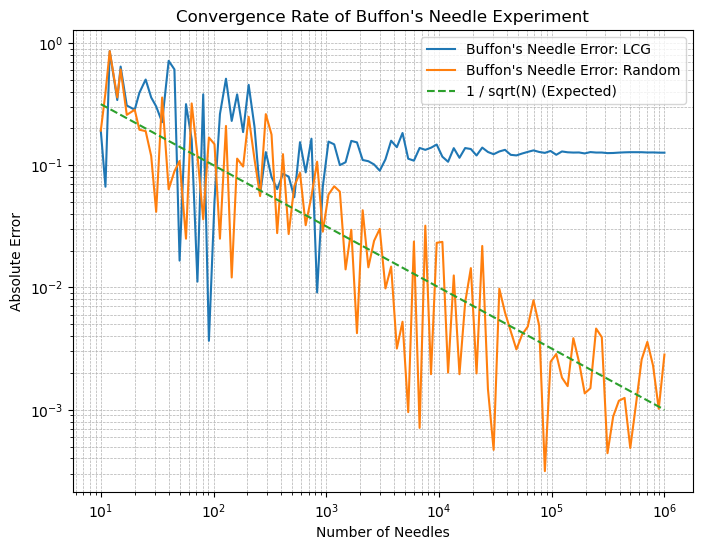

In [31]:
needle_counts, errors, errors_orig = calculate_convergence(NEEDLE_LENGTH, LINE_SPACING, NUM_NEEDLES)
handle_plotting(needle_counts, errors, errors_orig)

## Conclusion

Both accuracy and convergence speed require larger orders for magnitudes of iteration (10^4 and higher) to actually see the difference in the weaker and stronger PRNGs used.